<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter4/4_4_%E9%9A%A0%E3%82%8C%E3%83%9E%E3%83%AB%E3%82%B3%E3%83%95%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title install packages
!pip install japanize-matplotlib==1.1.3
!pip install arviz==0.11.4
!pip install tensorflow_probability==0.14.1
!pip install tensorflow==2.7.0
!pip install watermark

     |████████████████████████████████| 4.1 MB 8.7 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=f8ca365bc579e9e4bdfd271bcbc78c821cefcc149442a3854a8be18decd85646
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 1.6 MB 2.7 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: arviz
    Found existing installation: arviz 0.12.1
    Uninstalling arviz-0.12.1:
      Successfully uninstalled arviz-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 

In [2]:
#@title Import packages
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib 
import arviz as az

import tensorflow_probability as tfp
import tensorflow as tf
tfb = tfp.bijectors
tfd = tfp.distributions

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
colors = sns.color_palette('tab10')
japanize_matplotlib.japanize() 

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
#@title Utility functions
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}
    # from_tfpもあるが、実行するとeager_executionがオフにされてしまうなど現状使いづらいので、from_dictを用いている
    return az.from_dict(trace)

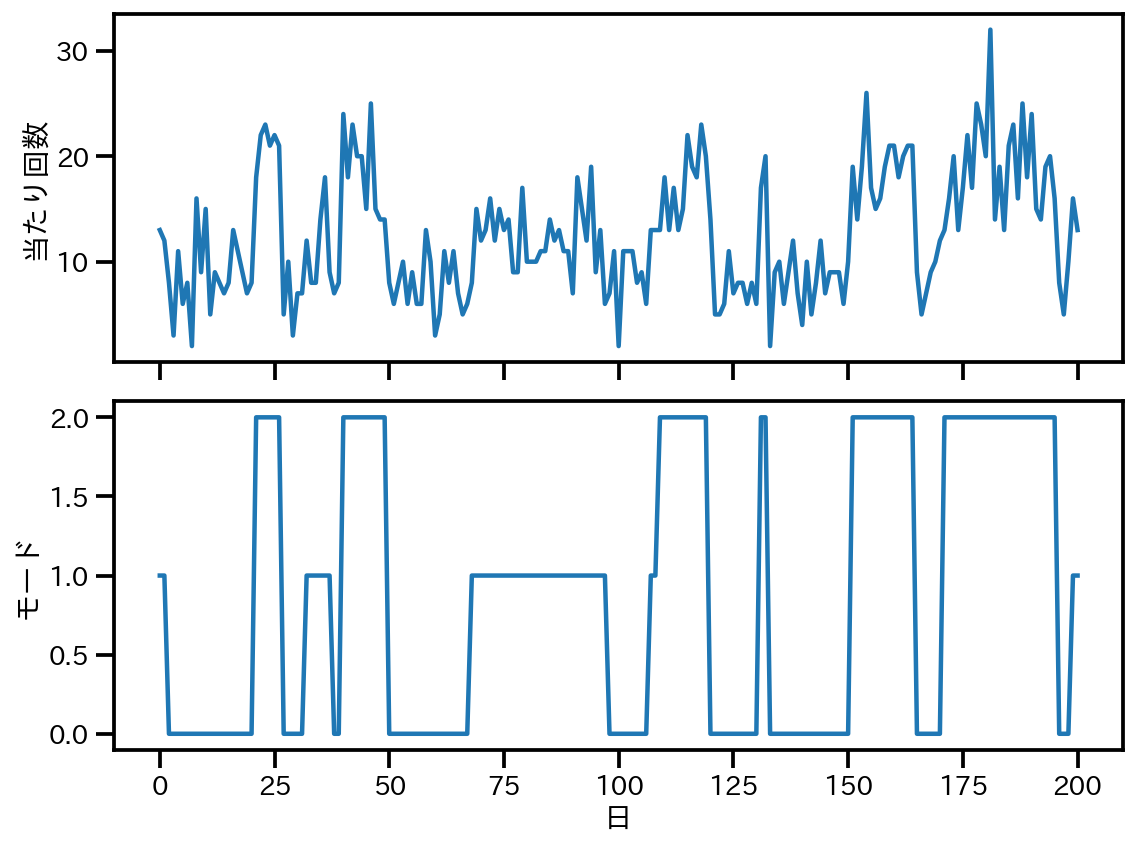

In [4]:
#@title generate simulation data
T = 200
n_state = 3
true_pi = [0.3, 0.6, 0.1]
true_A = [[0.91, 0.05, 0.04], [0.07, 0.90, 0.03], [0.04, 0.02, 0.94]]
true_lam = [8, 12, 18]

np.random.seed(1)
z_s = np.random.choice(n_state, p=true_pi)
z = [z_s]
for _ in range(T):
    z_s = np.random.choice(n_state, p=true_A[z_s])
    z.append(z_s)

x = np.random.poisson(np.array(true_lam)[z])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax = axes[0]
ax.plot(x)
ax.set_ylabel('当たり回数')
ax = axes[1]
ax.plot(z)
ax.set_ylabel('モード')
ax.set_xlabel('日')
plt.tight_layout()

In [5]:
num_states = 3
Root = tfd.JointDistributionCoroutine.Root

def model():
    initial_probs = yield Root(
        tfd.Dirichlet(concentration=tf.ones(num_states))) # event shape: [3]
        
    transition_probs = yield Root(
        tfd.Independent(
            tfd.Dirichlet(
                concentration=tf.ones((num_states, num_states))), 
            reinterpreted_batch_ndims=1)) # event shape: [3, 3]
    
    rates = yield Root(tfd.Sample(
        tfd.Gamma(concentration=2, rate=0.1), 
        sample_shape=num_states)) # event shape: [3]
    
    hmm = yield tfd.HiddenMarkovModel(
        # 初期確率
        initial_distribution=tfd.Categorical(probs=initial_probs),
        # 遷移確率
        transition_distribution=tfd.Categorical(probs=transition_probs),
        # 観測分布
        observation_distribution=tfd.Poisson(rate=rates),
        # 時点数
        num_steps=len(x))

joint = tfd.JointDistributionCoroutine(model)

# スカラー値が返ることを確認
tf.debugging.assert_scalar(joint.log_prob(joint.sample()), "you might misspecify shapes: ")
# NanやInfでないことを確認
tf.debugging.assert_all_finite(joint.log_prob(joint.sample()), "there are Nan's or Inf's")


def target_log_prob_fn(initial_probs, transition_probs, rates):
    return joint.log_prob(initial_probs, transition_probs, rates, x)

In [6]:
%%time
num_results = 2000
num_burnin_steps = 1000
n_chains = 3

tf.random.set_seed(42)

# パラメータの制約に合わせた変数変換
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.SoftmaxCentered(),
    tfb.Chain([
            tfb.Ascending(),
            tfb.Softplus()
            ])
]

# パラメータの初期値
current_state = [
    tf.ones([n_chains, num_states]) / num_states,
    tf.ones([n_chains, num_states, num_states]) / num_states,
    tf.stack([     
        tf.random.uniform([n_chains], 4, 9),
        tf.random.uniform([n_chains], 10, 15),
        tf.random.uniform([n_chains], 16, 21)
        ], axis=1)              
]

# ハミルトニアン・モンテカルロ法を用いる。step sizeというハイパーパラメータの調整が必要になるが、
# SimpleStepSizeAdaptationでラップすることで、自動的に調整してくれる。
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                ｔfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn=target_log_prob_fn,
                    step_size=0.1,
                    num_leapfrog_steps=10), 
                bijector=unconstraining_bijectors),  
            num_adaptation_steps=int(num_burnin_steps * 0.8))


# tf.functionでデコレートすることで、計算グラフがコンパイルされ、高速に実行される
@tf.function(autograph=False, experimental_compile=True)
def do_sampling(num_results, num_burnin_steps, current_state, kernel):
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=current_state,
      kernel=kernel)


states, kernel_results = do_sampling(num_results, num_burnin_steps, current_state, kernel)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/__init__.py:75: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  'TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The '
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 29.4 s, sys: 398 ms, total: 29.8 s
Wall time: 39.9 s


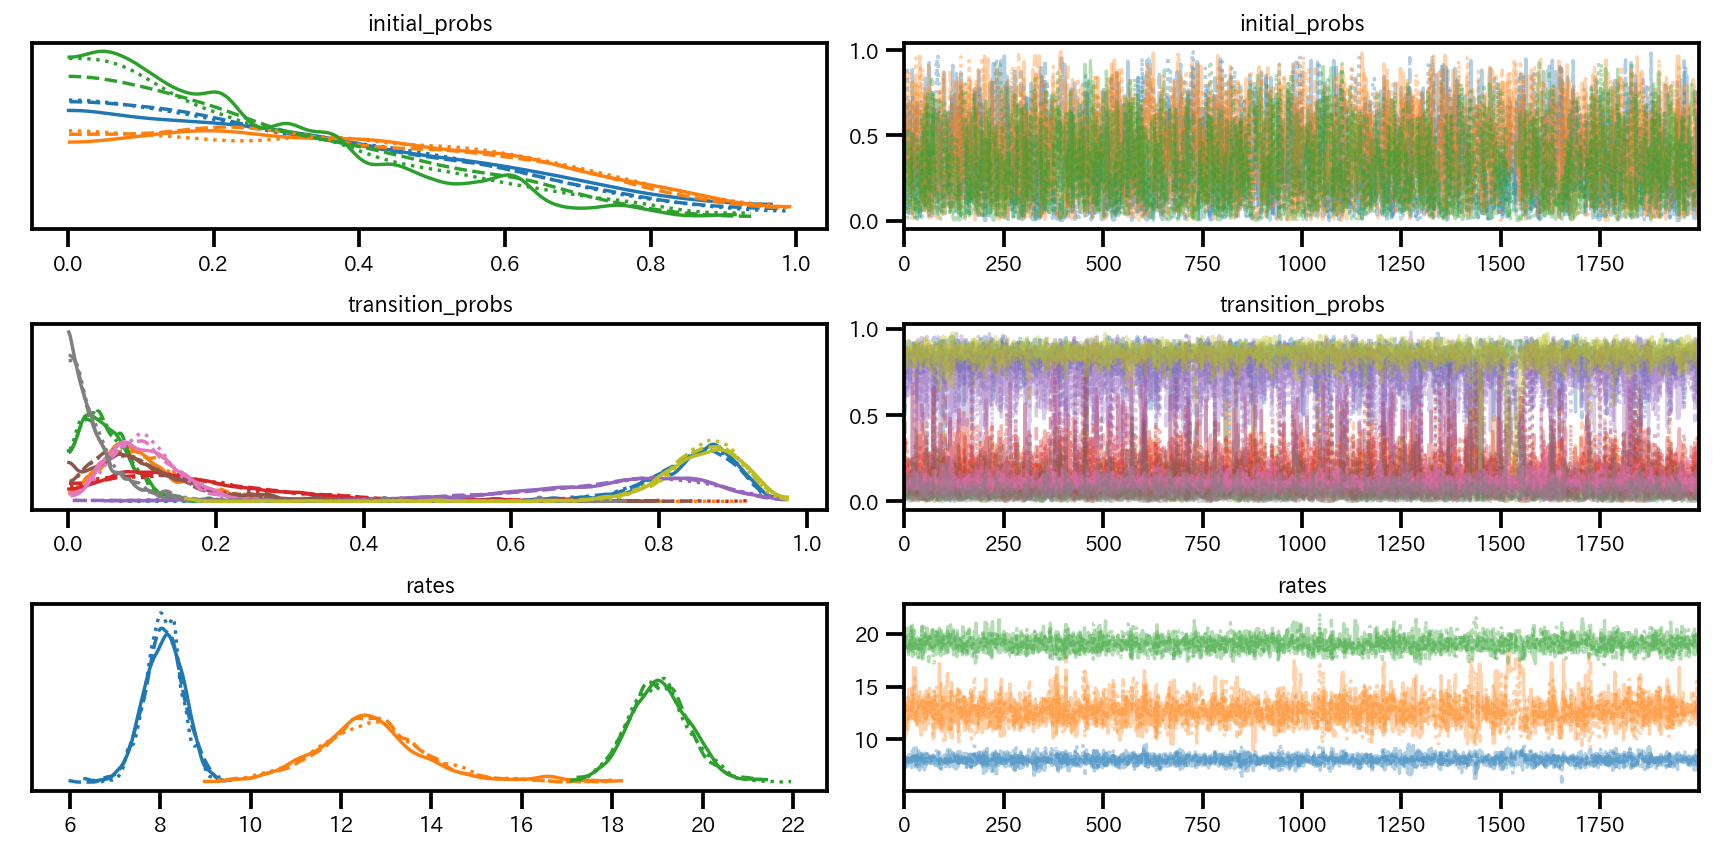

In [7]:
varnames = ["initial_probs", "transition_probs", "rates"]
trace = format_trace(states, varnames, chain_dim=1)
az.plot_trace(trace, var_names=["initial_probs", "transition_probs", "rates"])

plt.tight_layout()

In [8]:
display(az.summary(trace))

print(f'true initial probs:\n{true_pi}\n')
print(f'true transition probs:\n{true_A}\n')
print(f'true lambda:\n{true_lam}')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
initial_probs[0],0.337,0.237,0.000,0.752,0.007,0.005,1070.0,1500.0,1.00
initial_probs[1],0.389,0.243,0.001,0.801,0.007,0.005,1096.0,1048.0,1.00
initial_probs[2],0.274,0.208,0.000,0.653,0.009,0.007,441.0,762.0,1.00
"transition_probs[0, 0]",0.832,0.090,0.695,0.945,0.003,0.002,1560.0,1103.0,1.00
"transition_probs[0, 1]",0.116,0.087,0.004,0.247,0.003,0.002,1212.0,956.0,1.00
"transition_probs[0, 2]",0.051,0.033,0.002,0.108,0.001,0.001,966.0,899.0,1.00
"transition_probs[1, 0]",0.182,0.139,0.000,0.427,0.004,0.003,1284.0,1100.0,1.00
"transition_probs[1, 1]",0.707,0.174,0.348,0.949,0.006,0.004,1398.0,838.0,1.00
"transition_probs[1, 2]",0.111,0.092,0.000,0.262,0.003,0.002,560.0,586.0,1.00
"transition_probs[2, 0]",0.102,0.047,0.017,0.185,0.001,0.001,2580.0,1058.0,1.01


true initial probs:
[0.3, 0.6, 0.1]

true transition probs:
[[0.91, 0.05, 0.04], [0.07, 0.9, 0.03], [0.04, 0.02, 0.94]]

true lambda:
[8, 12, 18]


In [9]:
for var_info in az.rhat(trace).values():
    print(var_info.name)
    print(var_info.values.round(3), sep=' ')
    print()

initial_probs
[1.001 1.    1.002]

transition_probs
[[1.002 1.    1.001]
 [1.002 1.001 1.001]
 [1.008 1.001 1.007]]

rates
[1.004 1.005 1.001]



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff826931390>,
      dtype=object)

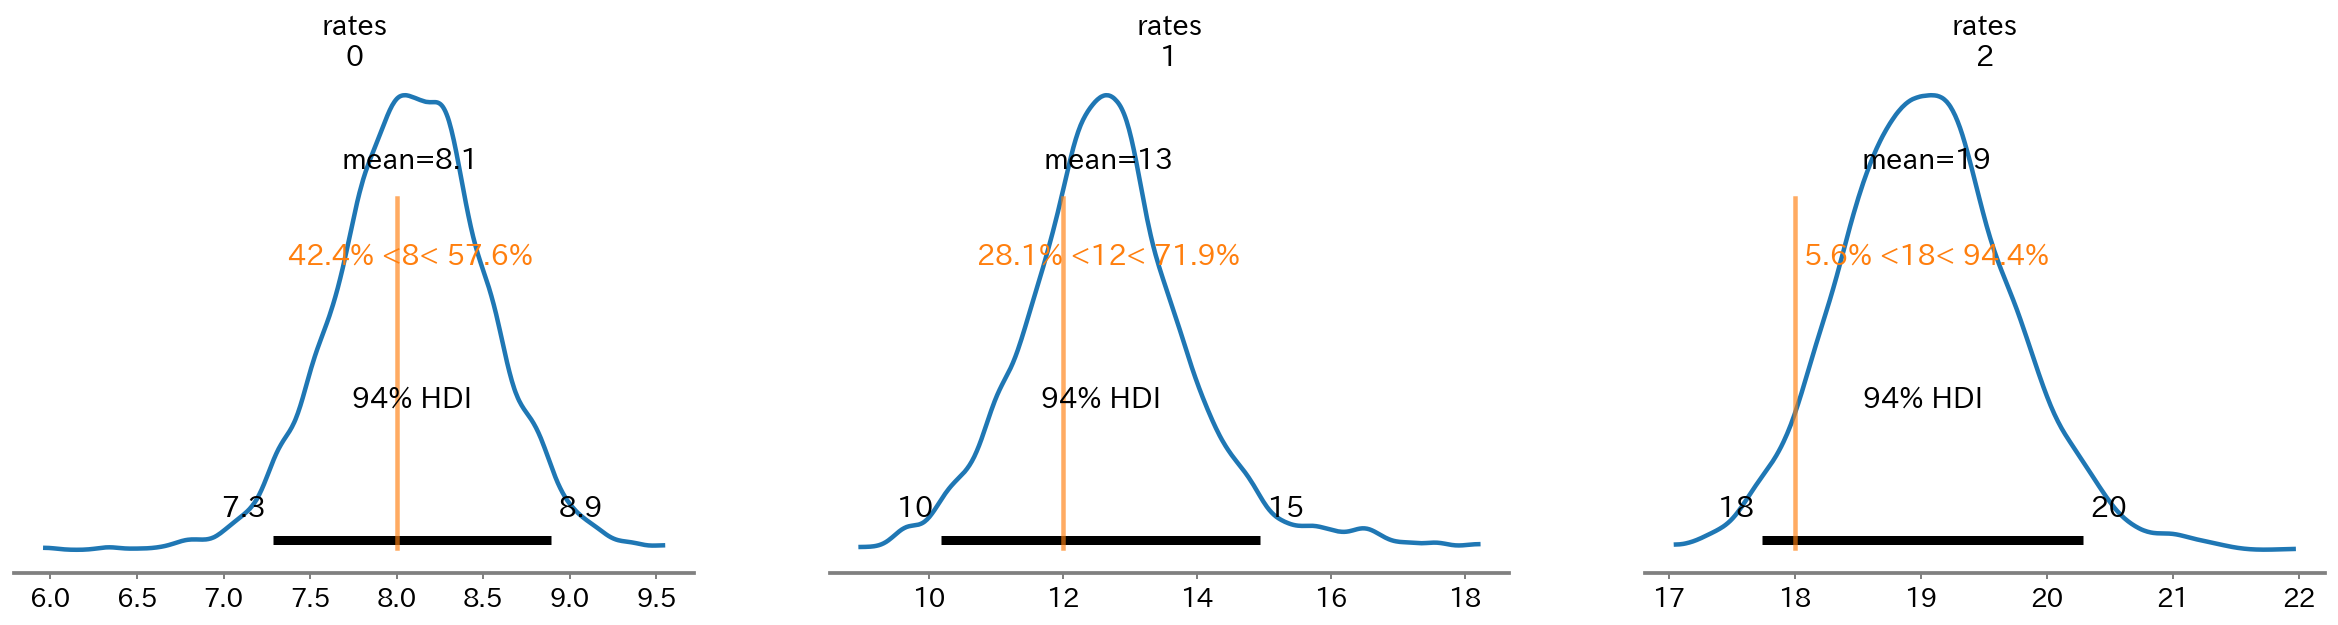

In [10]:
az.plot_posterior(trace, var_names=["rates"], ref_val=true_lam)

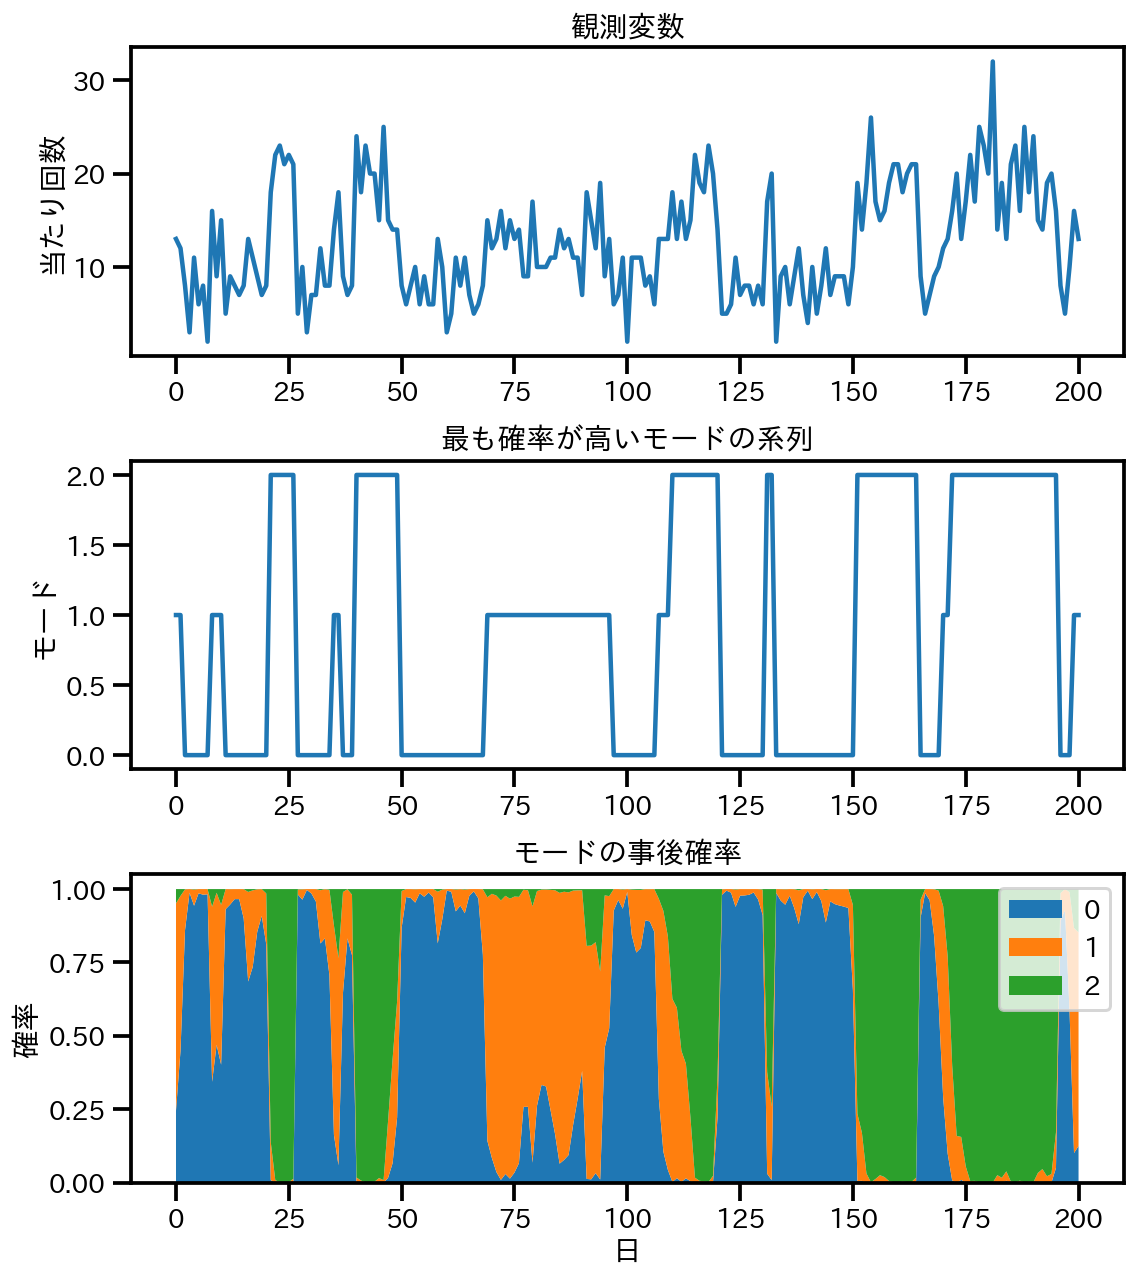

In [11]:
# 事後分布の平均を利用
hmm_post = tfd.HiddenMarkovModel(
        initial_distribution=tfd.Categorical(
            probs=trace.posterior['initial_probs'].mean(axis=(0,1))),
        transition_distribution=tfd.Categorical(
            probs=trace.posterior['transition_probs'].mean(axis=(0,1))),
        observation_distribution=tfd.Poisson(
            rate=trace.posterior['rates'].mean(axis=(0,1))),
        num_steps=len(x))

fig, axes = plt.subplots(3, 1, figsize=(8, 9))
ax=axes[0]
ax.plot(x)
ax.set_ylabel('当たり回数')
ax.set_title('観測変数')

ax=axes[1]
ax.plot(hmm_post.posterior_mode(x.astype(np.float32)))
ax.set_ylabel('モード')
ax.set_title('最も確率が高いモードの系列')

posterior_probs = hmm_post.posterior_marginals(
    x.astype(np.float32)).probs_parameter()
ax = axes[2]
ax.stackplot(np.arange(len(x)), posterior_probs.numpy().T, labels=[0,1,2])
ax.set_ylabel('確率')
ax.set_xlabel('日')
ax.set_title('モードの事後確率')
ax.legend()
plt.tight_layout()

In [12]:
%load_ext watermark
%watermark --iversions

matplotlib            : 3.2.2
numpy                 : 1.21.6
tensorflow            : 2.7.0
IPython               : 5.5.0
tensorflow_probability: 0.14.1
arviz                 : 0.11.4
seaborn               : 0.11.2
japanize_matplotlib   : 1.1.3

